# APTOS 2019 Blindness Detection
## Detect diabetic retinopathy to stop blindness before it's too late

### Submission: Aaron Balson
### Date: August 2019


Project Design:
1.	Setup ENV and download/import required packages.
2.	Load given datasets to understand its format.
3.	Exploratory data analysis on csv and images.
4.	Perform pre-processing, resizing/rescaling to match that of ImageNet (224x224) as we intend to use DenseNet (which was trained on ImageNet) for transfer learning.
5.	Use Multilabel instead of multiclass encoding. Eg: represent class 4 as [1,1,1,1,0] instead of traditional [0,0,0,1,0]
6.	Perform data augmentation using Data Generator since training set is small.
7.	Adopt DenseNet-121 Architecture and append our dense and output layers at end their conv layers.
8.	Train and evaluate model based on accuracy and kappa score.
9.  Plot training vs validation (accuracy & loss) to inspect overfitting.
    (Re-run the training with hyperparameters tuning and optimizers based on accuracy, kappa score (if needed))
10.	Test the model and submit to Kaggle for public score.


## **1. Setup ENV, download/import dependencies**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
from keras.applications.densenet import DenseNet121

from IPython.display import display


%matplotlib inline

EPOCHS = 20
BATCH_SIZE = 16
SEED = 20031976
LRATE = 0.00005

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


## **2. Load Datasets**

In [2]:
np.random.seed(SEED)
tf.set_random_seed(SEED)

train_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')
print("Datasets loaded..")

Datasets loaded..


## **3. Exploratory Data Analysis**

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4


,id_code
0,0005cfc8afb6
1,003f0afdcd15


train_df shape =  (3662, 2)
test_df shape =  (1928, 1)


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

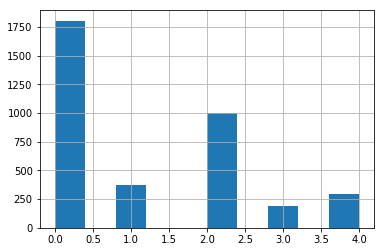

In [3]:
# Data
display(train_df.head(2))
display(test_df.head(2))

# Shape of data
print("train_df shape = ",train_df.shape)
print("test_df shape = ",test_df.shape)

# Distribution of data
display(train_df['diagnosis'].value_counts())
train_df['diagnosis'].hist()

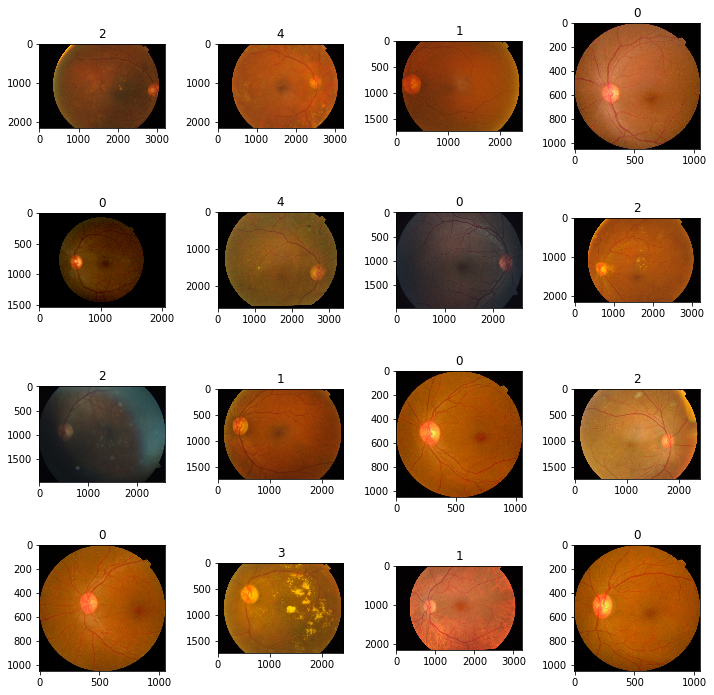

In [4]:
def display_image(df, rows, columns):
    fig=plt.figure(figsize=(10, 10))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/kaggle/input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_image(train_df, 4, 4)

## **4. Perform Pre-processing, Resampling**

**Observation** The dataset is highly imbalanced, with many samples for level 0, and very little for level 3,4. It also has very less samples (3662) compared to other similar retinopathy competitions (~30k). We will use under sampling and over sampling to balance the dataset with each class having 1000 samples.

Images are to be resized/rescaled to match that of ImageNet (224x224) as we intend to use ResNet50 or DenseNet50 (which were trained on ImageNet) for transfer learning.

In [5]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    return im

# Trail-1 Under sampling by deleting oversized classes (Class:0)
def under_sample_make_all_same(df, categories, max_per_category):
    df = pd.concat([df[df['diagnosis'] == c][:max_per_category] for c in categories])
    df = df.sample(n=(max_per_category)*len(categories), replace=False, random_state=20031976)
    df.index = np.arange(len(df))
    return df
#train_df = under_sample_make_all_same(train_df,[0,1,2,3,4], 193 ) 
#Under-sample class-0 (1805-805=1000) and Over-sample other classes so each class has 1000 entries
train_df = train_df.drop(train_df[train_df['diagnosis'] == 0].sample(n=805, replace=False).index)

N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)
#tqdm
for i, image_id in enumerate((train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'/kaggle/input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )
    
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate((test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'/kaggle/input/aptos2019-blindness-detection/test_images/{image_id}.png'
    )
    
y_train = pd.get_dummies(train_df['diagnosis']).values



In [6]:
print("x_train.shape=",x_train.shape)
print("y_train.shape=",y_train.shape)
print("x_test.shape=",x_test.shape)

x_train.shape= (2857, 224, 224, 3)
y_train.shape= (2857, 5)
x_test.shape= (1928, 224, 224, 3)


In [7]:
# Trail-2 Over sampling by increasing undersized classes
from imblearn.over_sampling import SMOTE, ADASYN
x_resampled, y_resampled = SMOTE(random_state=SEED).fit_sample(x_train.reshape(x_train.shape[0], -1), train_df['diagnosis'].ravel())

print("x_resampled.shape=",x_resampled.shape)
print("y_resampled.shape=",y_resampled.shape)

x_train = x_resampled.reshape(x_resampled.shape[0], 224, 224, 3)
y_train = pd.get_dummies(y_resampled).values

# Trail-3 No sampling

# Each class should have 1000 samples now (5 x 1000 = 5000)
print("x_train.shape=",x_train.shape)
print("y_train.shape=",y_train.shape)

x_resampled.shape= (5000, 150528)
y_resampled.shape= (5000,)
x_train.shape= (5000, 224, 224, 3)
y_train.shape= (5000, 5)


# 5.Creating Multilabels
Encoding a class by encompassing all the classes before it seems to work out well for kappa scores. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., encoding a class 4 retinopathy would usually be [0, 0, 0, 1, 0], but in our case we will predict [1, 1, 1, 1, 0]. For more details, please check out this paper on [Ordinal Regression](https://arxiv.org/abs/0704.1028), also implemented by [Lex's](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets) kernel.

In [8]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1000 1000 1000 1000 1000]
Multilabel version: [5000 4000 3000 2000 1000]


In [9]:
# Split 85-15 training-validation sets
x_sptrain, x_spval, y_sptrain, y_spval = train_test_split(
    x_train, y_train_multi, 
    test_size=0.10, 
    random_state=SEED
)
print("train-validation splitted ...")

train-validation splitted ...


# 6. Image Data Augmentation

In [10]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.10,        # set range for random zoom
        fill_mode='constant',   # set mode for filling points outside the input boundaries
        cval=0.,                # value used for fill_mode = "constant"
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images
        #rotation_range=20       # Degree range for random rotations
    )

# Using original generator
data_generator = create_datagen().flow(x_sptrain, y_sptrain, batch_size=BATCH_SIZE, seed=SEED)
print("Image data augmentated ...")

# 7. CNNetwork Architecture (DenseNet Transfer Learning)

In [11]:
# Define evaluation metrics

import keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*(p*r) / (p+r+K.epsilon())

print("Evaluation metrics defined ...")

Evaluation metrics defined ...


In [12]:
# Transfer Learning
densenet = DenseNet121(
    weights='/kaggle/input/densenet121/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=LRATE),
    metrics=['accuracy',mean_pred, precision, recall, f1_score, fbeta_score, fmeasure]
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# 8. Training Model

** Quadratic Weighted Kappa **
Quadratic Weighted Kappa (QWK, the greek letter  κ ), also known as Cohen's Kappa, is the official evaluation metric. For our kernel, we will use a custom callback to monitor the score, and plot it at the end.

What is the weighted kappa? The wikipedia page offer a very concise explanation:

> The weighted kappa allows disagreements to be weighted differently and is especially useful when codes are ordered. Three matrices are involved, the matrix of observed scores, the matrix of expected scores based on chance agreement, and the weight matrix. Weight matrix cells located on the diagonal (upper-left to bottom-right) represent agreement and thus contain zeros. Off-diagonal cells contain weights indicating the seriousness of that disagreement.
> 
Simply put, if two scores disagree, then the penalty will depend on how far they are apart. That means that our score will be higher if (a) the real value is 4 but the model predicts a 3, and the score will be lower if (b) the model instead predicts a 0. This metric makes sense for this competition, since the labels 0-4 indicates how severe the illness is. Intuitively, a model that predicts a severe retinopathy (3) when it is in reality a proliferative retinopathy (4) is probably better than a model that predicts a mild retinopathy (1).

In [13]:
# callback to keep track of kappa score during training
class KappaMetrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []
        
    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return
    
kappa_score = KappaMetrics()



history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_spval, y_spval),
    callbacks=[kappa_score],
    verbose=1
)    

Epoch 1/20
313/312 [==============================] - 101s 322ms/step - loss: 0.3497 - acc: 0.8369 - mean_pred: 0.5573 - precision: 0.8817 - recall: 0.8425 - f1_score: 0.8569 - fbeta_score: 0.8569 - fmeasure: 0.8569 - val_loss: 0.2427 - val_acc: 0.8988 - val_mean_pred: 0.5715 - val_precision: 0.9548 - val_recall: 0.8789 - val_f1_score: 0.9138 - val_fbeta_score: 0.9138 - val_fmeasure: 0.9138
val_kappa: 0.7765
Validation Kappa has improved. Saving model.
Epoch 2/20
313/312 [==============================] - 67s 215ms/step - loss: 0.2083 - acc: 0.9128 - mean_pred: 0.5891 - precision: 0.9383 - recall: 0.9177 - f1_score: 0.9261 - fbeta_score: 0.9261 - fmeasure: 0.9261 - val_loss: 0.1818 - val_acc: 0.9216 - val_mean_pred: 0.6233 - val_precision: 0.9388 - val_recall: 0.9345 - val_f1_score: 0.9355 - val_fbeta_score: 0.9355 - val_fmeasure: 0.9355
val_kappa: 0.8448
Validation Kappa has improved. Saving model.
Epoch 3/20
313/312 [==============================] - 67s 213ms/step - loss: 0.1795 - a

val_kappa: 0.9002
Epoch 20/20
313/312 [==============================] - 67s 214ms/step - loss: 0.0342 - acc: 0.9881 - mean_pred: 0.5994 - precision: 0.9897 - recall: 0.9905 - f1_score: 0.9899 - fbeta_score: 0.9899 - fmeasure: 0.9899 - val_loss: 0.1514 - val_acc: 0.9580 - val_mean_pred: 0.6015 - val_precision: 0.9800 - val_recall: 0.9524 - val_f1_score: 0.9653 - val_fbeta_score: 0.9653 - val_fmeasure: 0.9653
val_kappa: 0.9186
Validation Kappa has improved. Saving model.


# 9. Evaluate model using metrics

In [14]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df.head(EPOCHS)

,val_loss,val_acc,val_mean_pred,val_precision,val_recall,val_f1_score,val_fbeta_score,val_fmeasure,loss,acc,mean_pred,precision,recall,f1_score,fbeta_score,fmeasure
0,0.242692,0.8988,0.571460,0.954752,0.878852,0.913800,0.913800,0.913800,0.348454,0.837270,0.557213,0.882698,0.842092,0.857505,0.857505,0.857505
1,0.181811,0.9216,0.623261,0.938841,0.934455,0.935469,0.935469,0.935469,0.207953,0.912930,0.588970,0.938516,0.917766,0.926267,0.926267,0.926267
2,0.164996,0.9320,0.580057,0.976964,0.911185,0.942123,0.942123,0.942123,0.178998,0.926821,0.595145,0.948483,0.931405,0.938514,0.938514,0.938514
3,0.153668,0.9372,0.624656,0.949525,0.949789,0.948508,0.948508,0.948508,0.159839,0.935468,0.595750,0.950642,0.943520,0.945567,0.945567,0.945567
4,0.165806,0.9336,0.589236,0.973679,0.917685,0.943465,0.943465,0.943465,0.143262,0.941713,0.602562,0.956284,0.949282,0.951401,0.951401,0.951401
5,0.318370,0.8852,0.518916,0.986892,0.826134,0.897390,0.897390,0.897390,0.122603,0.951321,0.597579,0.964078,0.955850,0.959044,0.959044,0.959044
6,0.178620,0.9364,0.586648,0.970450,0.925188,0.946314,0.946314,0.946314,0.110103,0.956445,0.593693,0.965101,0.962437,0.962830,0.962830,0.962830
7,0.142301,0.9464,0.594723,0.974744,0.938204,0.954822,0.954822,0.954822,0.102363,0.958767,0.598659,0.967350,0.965054,0.965334,0.965334,0.965334
8,0.161821,0.9492,0.582887,0.982357,0.933792,0.956443,0.956443,0.956443,0.089253,0.965893,0.598051,0.973719,0.970461,0.971493,0.971493,0.971493
9,0.187924,0.9344,0.580995,0.976283,0.916614,0.944452,0.944452,0.944452,0.076064,0.970586,0.596443,0.975048,0.976130,0.975024,0.975024,0.975024


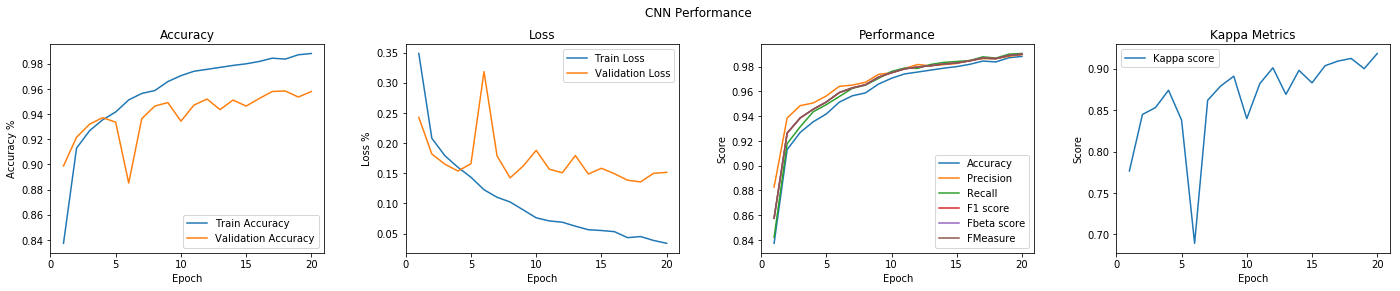

In [22]:
#history_df[['loss', 'val_loss']].plot()
#history_df[['acc', 'val_acc']].plot()
#history_df[['acc', 'precision', 'recall', 'f1_score', 'fbeta_score', 'fmeasure']].plot()

f1, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
t1 = f1.suptitle('CNN Performance', fontsize=12)
f1.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS + 1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax1.set_ylabel('Accuracy %')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax2.set_ylabel('Loss %')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax3.plot(epoch_list, history.history['acc'], label='Accuracy')
ax3.plot(epoch_list, history.history['precision'], label='Precision')
ax3.plot(epoch_list, history.history['recall'], label='Recall')
ax3.plot(epoch_list, history.history['f1_score'], label='F1 score')
ax3.plot(epoch_list, history.history['fbeta_score'], label='Fbeta score')
ax3.plot(epoch_list, history.history['fmeasure'], label='FMeasure')
ax3.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax3.set_ylabel('Score')
ax3.set_xlabel('Epoch')
ax3.set_title('Performance')
l3 = ax3.legend(loc="best")

ax4.plot(epoch_list, kappa_score.val_kappas, label='Kappa score')
ax4.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax4.set_ylabel('Score')
ax4.set_xlabel('Epoch')
ax4.set_title('Kappa Metrics')
l4 = ax4.legend(loc="best")



** Observation: ** Model has shown good learning capability. It seems to generalize well since training vs validation accuracy are within 4% and loss within 0.1%. We can increase few more epoch to further train to acheive better kappa score without starting to overfit.

# 10. Predict & Submit for results


In [23]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)
display(test_df.head(5))

import datetime
print("Ran at UTC : ", datetime.datetime.utcnow())


,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2


Ran at UTC :  2019-08-14 09:54:15.413930
